In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import warnings


In [9]:
warnings.filterwarnings('ignore')
#To ignore warnings in the outputs

Loading Data

In [10]:
train_df = pd.read_csv('/mnt/d/School NEw/Sem VII/PredictiveFleetMaintenance/aps_failure_test_set.csv')
test_df=pd.read_csv('/mnt/d/School NEw/Sem VII/PredictiveFleetMaintenance/aps_failure_training_set.csv')
#Creating one dataframe of both the train and test data
df = pd.concat([train_df, test_df], ignore_index=True)
#Converting this to a neumeric column 
df['class'] = df['class'].replace({'pos': 1, 'neg': 0})

X = df.drop('class', axis=1)#Class is the feature we are predicting thus we remove class from the X dataframe
y = df['class']# As we are predicting class, it is our y dataframe


In [11]:
print(f"Step 2: Data loaded. Total records: {len(df)}, Features: {len(X.columns)}")
print(f"Failure cases (pos): {y.sum()}, Normal cases (neg): {len(y) - y.sum()}")

Step 2: Data loaded. Total records: 76000, Features: 170
Failure cases (pos): 1375, Normal cases (neg): 74625


Checking Target Class Imballance

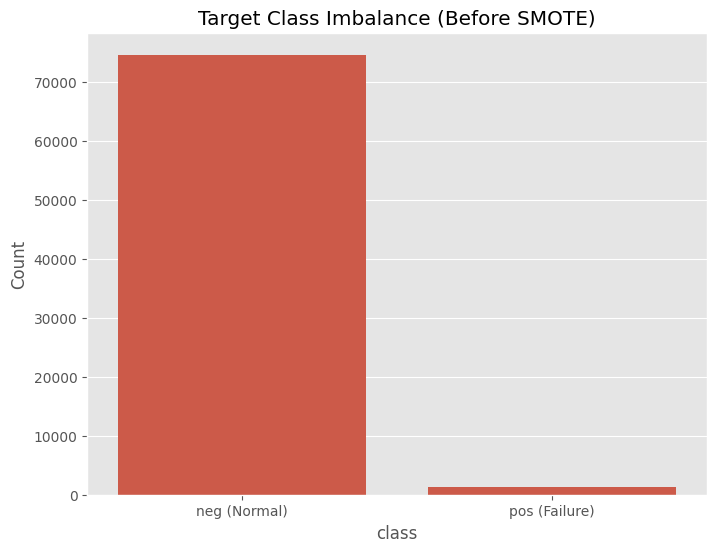

In [12]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Target Class Imbalance (Before SMOTE)')
plt.xticks([0, 1], ['neg (Normal)', 'pos (Failure)'])
plt.ylabel('Count')
plt.savefig('target_imbalance.png')
plt.show()

In [13]:
missing_percent = (X.isna().sum() / len(X)) * 100 #Checking for NaN values
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    plt.figure(figsize=(12, 8))
    missing_percent.head(20).plot(kind='barh')
    plt.title('Top 20 Features by Percentage of Missing Data (Before Imputation)')
    plt.xlabel('Percentage Missing (%)')
    plt.savefig('missing_data_head.png')
    print("  - Generated 'missing_data_head.png'")
else:
    print("  - No missing data found to plot.")

  - No missing data found to plot.


Preprocessing

In [14]:
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median()) #Filling any Na values witht he median to clean the data

print(f"  - Missing values successfully imputed. Total remaining NaNs: {X.isnull().sum().sum()}")#Checking if there are any remaining NaN values
#Inorder to add a lattitude and longitude, i used random numbers to simulate this problem in the city of Chicago
np.random.seed(42)
CHICAGO_LAT, CHICAGO_LON = 41.8781, -87.6298
FLEET_SIZE = len(X)
X['lat'] = np.random.normal(CHICAGO_LAT, 0.5, FLEET_SIZE)
X['lon'] = np.random.normal(CHICAGO_LON, 0.5, FLEET_SIZE)

  - Missing values successfully imputed. Total remaining NaNs: 0


  - Generated 'geo_distribution.png'
  - Train/Test split completed. Training size: 53200, Testing size: 22800


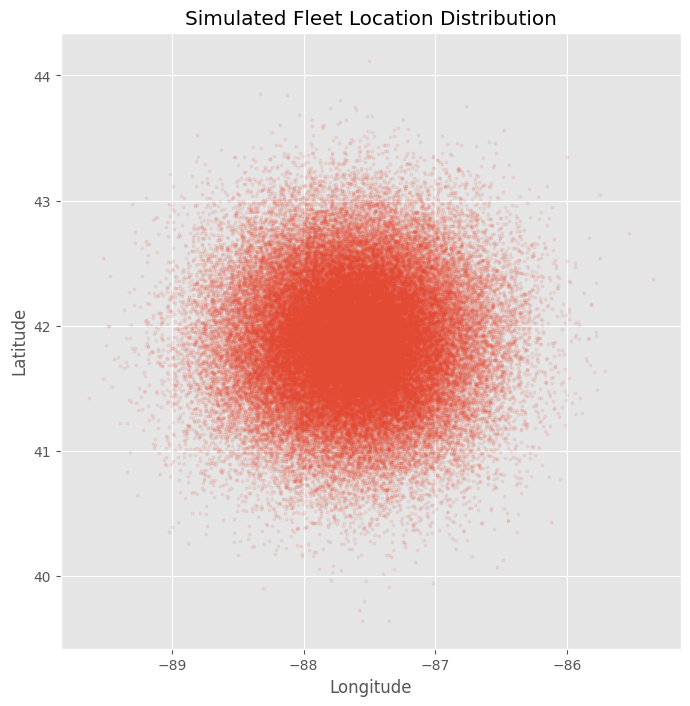

In [15]:
#Plotting the distribution of the fleet to help visulaise this  on a grid
plt.figure(figsize=(8, 8))
plt.scatter(X['lon'], X['lat'], s=5, alpha=0.1)
plt.title('Simulated Fleet Location Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('geo_distribution.png')
print("  - Generated 'geo_distribution.png'")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)#70% Train 30% Test data 

print(f"  - Train/Test split completed. Training size: {len(X_train)}, Testing size: {len(X_test)}")

Applying SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance

Why do we need to address class imbalance?

Our data has 98% negative (normal trucks) values and only 2% failure values. The model would have predicted almost all values as normal. Although this would appear to be high accuracy, it would be incorrect and of no real use, as the purpose is to preemptively predict failures. Thus, this was an important issue to address.

Why did I choose SMOTE?

In our dataset, SMOTE starts by picking one failure point. It then identifies the other failure points that are closest to it, extrapolates a line or pattern to generate more points that match the original pattern, thus adding more failure points, balancing the data, and allowing the model to learn the failure patterns more effectively.

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)#Appling SMOTE to my data

print(f"  - SMOTE applied. New training set size: {len(X_train_resampled)}")

  - SMOTE applied. New training set size: 104474


In [17]:
mlflow.set_experiment("Predictive_Fleet_Maintenance")

<Experiment: artifact_location='file:///home/karan/mlruns/358824054278599100', creation_time=1761411606630, experiment_id='358824054278599100', last_update_time=1761411606630, lifecycle_stage='active', name='Predictive_Fleet_Maintenance', tags={}>

Using the light gradient boosted machine<br>
We start  my naming the MLflow  experiental run LGBM_Geospatial_Risk_Model_v2<br>
Why did i choose a LGBM model?<br>
1. Speed: For large datasets like ours, it is one of the fastest and most memory efficient models
2. Accuracy: Very good for tabular data 
3. Handeling many features: As our dataset has 170+ features, this model is optimal for automatically choosing  which features are important

Step 5: Starting MLflow run to train and track the model.
[LightGBM] [Info] Number of positive: 52237, number of negative: 52237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42947
[LightGBM] [Info] Number of data points in the train set: 104474, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2025/10/26 10:33:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  - F1-Score: 0.8184
  - Precision: 0.8164
  - Recall: 0.8204


2025/10/26 10:34:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  - Model training complete and logged to MLflow.
  - Generated and logged 'feature_importance.png'


<Figure size 1000x800 with 0 Axes>

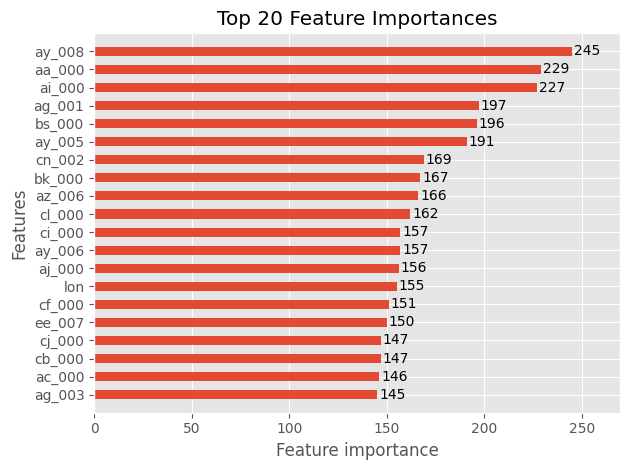

In [18]:

with mlflow.start_run(run_name="LGBM_Geospatial_Risk_Model_v2"):
    print("Step 5: Starting MLflow run to train and track the model.")
    
    mlflow.log_artifact('target_imbalance.png')
    if not missing_percent.empty:
        mlflow.log_artifact('missing_data_head.png')
    mlflow.log_artifact('geo_distribution.png')

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'num_leaves': 20,
        'max_depth': 5,
        'is_unbalance': True,
        'random_state': 42
    }
    mlflow.log_params(params)

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled,
              eval_set=[(X_test, y_test)],
              eval_metric='f1',
              callbacks=[lgb.early_stopping(50, verbose=False)])

    predictions = model.predict(X_test)
    pred_probs = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    print(f"  - F1-Score: {f1:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")

    mlflow.sklearn.log_model(model, "lgbm-risk-classifier")
    print("  - Model training complete and logged to MLflow.")

    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5)
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    mlflow.log_artifact('feature_importance.png')
    print("  - Generated and logged 'feature_importance.png'")

In [19]:
print("Step 6: Generating geospatial failure hotspot map.")

results_df = X_test.copy()

results_df['failure_probability'] = pred_probs
results_df['actual_failure'] = y_test

RISK_THRESHOLD = 0.7
high_risk_vehicles = results_df[results_df['failure_probability'] > RISK_THRESHOLD]

risk_map = folium.Map(location=[CHICAGO_LAT, CHICAGO_LON], zoom_start=8)

for _, vehicle in high_risk_vehicles.iterrows():
    folium.CircleMarker(
        location=[vehicle['lat'], vehicle['lon']],
        radius=8,
        color='red',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.6,
        popup=f"Failure Probability: {vehicle['failure_probability']:.2%}"
    ).add_to(risk_map)

MAP_FILE = '/mnt/d/School NEw/Sem VII/PredictiveFleetMaintenance/failure_hotspot_map.html'
risk_map.save(MAP_FILE)

print(f"  - Map saved as '{MAP_FILE}'. Open this file in a browser to view.")

Step 6: Generating geospatial failure hotspot map.
  - Map saved as '/mnt/d/School NEw/Sem VII/PredictiveFleetMaintenance/failure_hotspot_map.html'. Open this file in a browser to view.
